In [36]:
import re
import pandas as pd

def parse_file(path):
    rows = []
    current = {}

    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            if "=== Trade Session Summary ===" in line:
                m = re.search(r"(\d{4}\.\d{2}\.\d{2}\s+\d{2}:\d{2}:\d{2})", line)
                if m:
                    current = {"datetime": m.group(1)}
                else:
                    current = {}
            elif "ATR (M1):" in line:
                m = re.search(r"ATR \(M1\):\s*([\d.]+)", line)
                if m:
                    current["atr_m1"] = float(m.group(1))
            elif "ADX:" in line:
                m = re.search(r"ADX:\s*([-\d.]+)", line)
                if m:
                    current["adx"] = float(m.group(1))
            elif "Bollinger Bands:" in line:
                m = re.search(r"Bollinger Bands: Upper=([-\d.]+), Lower=([-\d.]+)", line)
                if m:
                    current["bb_upper"] = float(m.group(1))
                    current["bb_lower"] = float(m.group(2))
            elif "Total PnL:" in line:
                m = re.search(r"Total PnL:\s*\$([-\d.]+)", line)
                if m:
                    current["pnl"] = float(m.group(1))
            elif "Current Balance:" in line:
                m = re.search(r"Current Balance:\s*\$([-\d.]+)", line)
                if m:
                    current["balance"] = float(m.group(1))
            elif "============================" in line:
                if current:
                    rows.append(current)
                current = {}
    return rows

rows = parse_file("log.txt")
df = pd.DataFrame(rows)
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime')
df = df.dropna()
df['is_profit'] = df['pnl'] > 0
print(df)


               datetime  atr_m1    adx  bb_upper  bb_lower     pnl   balance  \
0   2019-11-01 04:35:11   23.43  24.13   1512.29   1512.29 -100.10  49899.90   
1   2019-11-01 04:55:01   25.14  48.62   1512.06   1512.06  939.90  50839.80   
2   2019-11-01 11:31:42   34.50  51.56   1513.65   1513.65  547.60  49855.40   
3   2019-11-01 12:11:51   42.36  37.79   1512.83   1512.83 -269.70  49093.30   
4   2019-11-01 12:40:14   23.29  48.46   1512.95   1512.95  172.48  49265.78   
..                  ...     ...    ...       ...       ...     ...       ...   
419 2019-12-12 18:53:03   39.50  26.36   1466.94   1466.94  -20.54   5149.81   
420 2019-12-12 19:57:42   36.43  31.05   1468.17   1468.17   81.37   5179.34   
421 2019-12-12 20:14:12   48.21  17.69   1468.01   1468.01   13.92   5193.26   
422 2019-12-12 21:56:30   56.79  36.82   1468.18   1468.18   -3.69   5137.49   
423 2019-12-12 22:17:21   44.86  49.41   1469.21   1469.21  -10.12   5075.89   

     is_profit  
0        False  
1    

In [37]:
# Show group means for all indicators (ADX, ATR (M1), Bollinger Bands)
indicator_cols = [
    "atr_m1", "adx", "bb_upper", "bb_lower", "pnl"
 ]
print(df.groupby("is_profit")[indicator_cols].mean())


              atr_m1        adx     bb_upper     bb_lower         pnl
is_profit                                                            
False      37.357051  27.275769  1469.932372  1469.932372  -72.985641
True       46.797201  34.312575  1472.642239  1472.642239  292.111157


In [38]:
from sklearn.ensemble import RandomForestClassifier

indicator_cols = [
    "atr_m1", "adx", "bb_upper", "bb_lower"
 ]

model = RandomForestClassifier(random_state=42)
model.fit(df[indicator_cols], df["is_profit"])
print(model.feature_importances_)


[0.27422271 0.30496036 0.2134905  0.20732644]


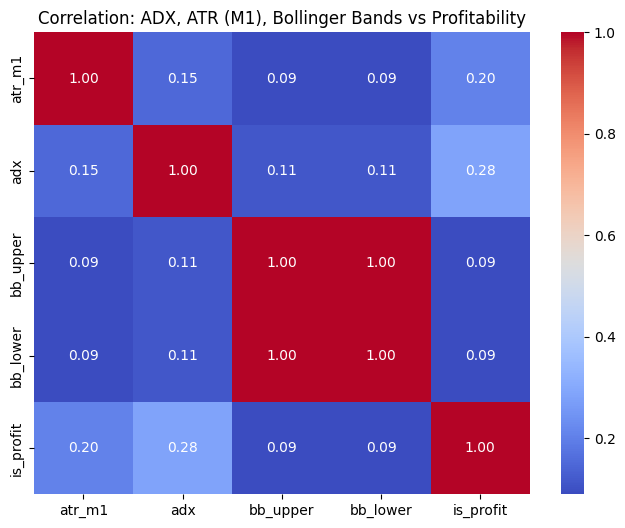

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

indicator_cols = [
    "atr_m1", "adx", "bb_upper", "bb_lower"
 ]

corrs = df[indicator_cols + ["is_profit"]].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corrs, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation: ADX, ATR (M1), Bollinger Bands vs Profitability")
plt.show()


In [40]:
print(corrs["is_profit"].sort_values(ascending=False))

is_profit    1.000000
adx          0.282732
atr_m1       0.204192
bb_upper     0.090974
bb_lower     0.090974
Name: is_profit, dtype: float64



Descriptive statistics (profitable vs losing):

--- adx ---
           count       mean     50%        std
is_profit                                     
False      156.0  27.275769  26.480   8.701184
True       268.0  34.312575  31.935  12.904387

--- atr_m1 ---
           count       mean     50%        std
is_profit                                     
False      156.0  37.357051  32.605  19.574575
True       268.0  46.797201  42.035  23.108199

--- bb_width ---
           count  mean  50%  std
is_profit                       
False      156.0   0.0  0.0  0.0
True       268.0   0.0  0.0  0.0

Searching quantile-based thresholds for each indicator...

Recommended thresholds (based on quantile search):
- adx: >= 55.3965  -> profit_rate=1.000  (support=22)
- atr_m1: >= 65.1400  -> profit_rate=0.800  (support=65)
- bb_width: >= 0.0000  -> profit_rate=0.632  (support=424)

Baseline profit rate: 0.632 (n=424)


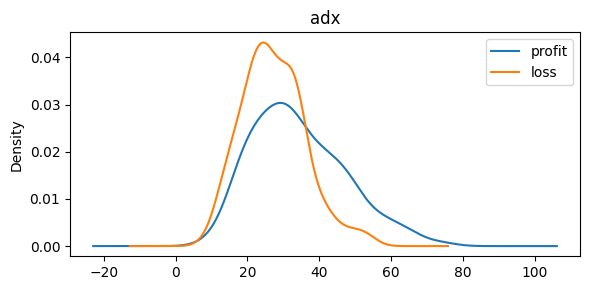

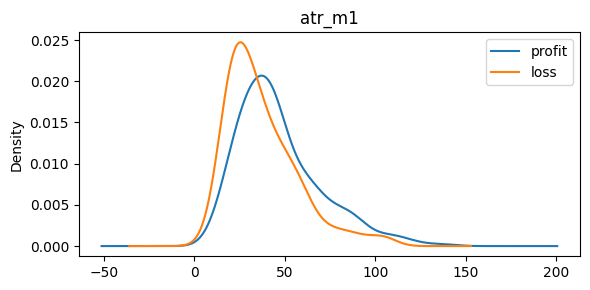

Plotting failed: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principal component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.


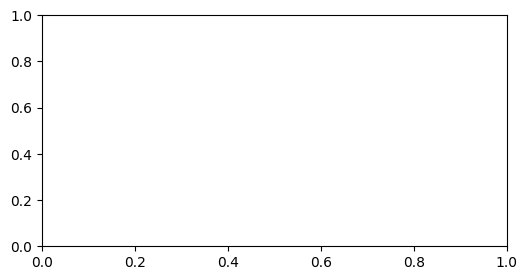

In [41]:
# Determine best indicator values (thresholds) for profitable trades
# Derive band width and compute descriptive stats + threshold search

# Ensure required columns exist
df = df.copy()
if 'bb_upper' in df.columns and 'bb_lower' in df.columns:
    df['bb_width'] = df['bb_upper'] - df['bb_lower']
else:
    df['bb_width'] = None

indicators = ['adx', 'atr_m1', 'bb_width']

print('\nDescriptive statistics (profitable vs losing):')
for ind in indicators:
    if ind not in df.columns or df[ind].isnull().all():
        print(f"\n- {ind}: no data")
        continue
    print(f"\n--- {ind} ---")
    try:
        desc = df.groupby('is_profit')[ind].describe()
        print(desc[['count','mean','50%','std']])
    except Exception:
        print(df.groupby('is_profit')[ind].describe())

# Threshold search using quantiles
print('\nSearching quantile-based thresholds for each indicator...')
recommendations = []
for ind in indicators:
    if ind not in df.columns or df[ind].dropna().empty:
        continue
    # compute direction: higher mean in profitable trades -> we look for >= threshold
    mean_profit = df.loc[df['is_profit'], ind].mean()
    mean_loss = df.loc[~df['is_profit'], ind].mean()
    higher_better = (mean_profit >= mean_loss)

    qs = list(df[ind].quantile([i/100 for i in range(5,96,5)]).unique())
    best = None
    for t in qs:
        if pd.isna(t):
            continue
        if higher_better:
            cond = df[ind] >= t
        else:
            cond = df[ind] <= t
        subset = df[cond]
        if len(subset) < 5:
            continue
        profit_rate = subset['is_profit'].mean()
        support = len(subset)
        # prefer higher profit_rate, tie-breaker larger support
        score = (profit_rate, support)
        if best is None or score > (best[0], best[2]):
            best = (profit_rate, t, support, higher_better)
    if best is not None:
        recommendations.append((ind, best[1], best[0], best[2], best[3]))

# Print recommendations
print('\nRecommended thresholds (based on quantile search):')
for ind, t, profit_rate, support, higher_better in recommendations:
    op = '>=' if higher_better else '<='
    print(f"- {ind}: {op} {t:.4f}  -> profit_rate={profit_rate:.3f}  (support={support})")

# Also show baseline profit rate and sample sizes
baseline = df['is_profit'].mean()
print(f"\nBaseline profit rate: {baseline:.3f} (n={len(df)})")

# Optionally plot indicator distributions split by profit
try:
    import matplotlib.pyplot as plt
    for ind in indicators:
        if ind in df.columns and not df[ind].dropna().empty:
            plt.figure(figsize=(6,3))
            df[df['is_profit']][ind].plot(kind='kde', label='profit')
            df[~df['is_profit']][ind].plot(kind='kde', label='loss')
            plt.title(ind)
            plt.legend()
            plt.tight_layout()
            plt.show()
except Exception as e:
    print('Plotting failed:', e)
